In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from states import make_state
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import curve_fit
from os import makedirs
import matplotlib.pyplot as plt
import measures as ms
import numpy as np
%matplotlib inline
der=r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/"

In [2]:
import qca
import core
from importlib import reload
reload(qca)
reload(core)
from qca import QCA

In [ ]:
# Parameters template
params_template = dict(
              L=15,
              T=100.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c1_f0",
              E=0.0,
              N=500,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

# define variable parameters
ICs = ["P123", "c1_f0"]    # seeded random throw, centered bit flip
Es = [0.0, 0.02/3, 0.10/3] # error rate

# initialize plots
fig1, ax1 = plt.subplots(1,1, figsize=(2.5,2))
fig2, ax2 = plt.subplots(1,1, figsize=(2.5,2))
fig3, ax3 = plt.subplots(1,1, figsize=(2.5,2))
fig4, ax4 = plt.subplots(1,1, figsize=(2.5,2))

# make a directory for the figures
makedirs("figures", exist_ok=True)

# loop through variable parameters
for IC, ls in zip(ICs, ["--", "-"]):
    fig5, ax5 = plt.subplots(1,3, figsize=(4,3), sharex=True, sharey=True)
    for i, (E,c) in enumerate(zip(Es, ("crimson","darkgrey", "k"))):
        # update parameters dictionary with new values
        params = copy(params_template)
        params.update({"IC": IC, "E": E})
        if E == 0.0:
            # no need to average if there is no noise.
            params.update({"N":1})
        # create a QCA object
        Q = QCA(params, der=der)
        # Run dynamic density matricies with posssible tasks:
        # rhoj = single-site
        # rhojk = two-site
        # bipart = all bipartitionings
        # bisect =  central bipartitioning
        Q.run(tasks=["rhoj", "rhojk", "bipart"], verbose=True)
        
        # calculate mutual information with
        # second order renyi entropies.
        # Save this intermediate result,
        # otherwise each call to a 
        # network meaure will recalculate from from density matricies
        # Setting to False trades memory for computation time
        Q.MI(2, save=True)
        
        # slice off the first value in the plots below
        # since entropy is initialy zero, but we'd like to visualize
        # on a log scale.
        # plot second order renyi entropy of center cut:
        ax1.plot(Q.ts[1:], Q.sbipart(2)[1:, Q.L//2], c=c, ls=ls)
        ax1.set_ylabel(r"$s_{:L/2}$")
        ax1.set_xlabel(r"$t$")
        # plot second order clustering
        ax2.semilogy(Q.ts[1:], Q.C(2)[1:], c=c, ls=ls)
        ax2.set_ylabel(r"$\mathcal{C}$")
        ax2.set_xlabel(r"$t$")
        # plot second order density
        ax3.semilogy(Q.ts[1:], Q.D(2)[1:], c=c, ls=ls)
        ax3.set_ylabel(r"$\mathcal{D}$")
        ax3.set_xlabel(r"$t$")
        # plot second order disparity
        ax4.semilogy(Q.ts[1:], Q.Y(2)[1:], c=c, ls=ls)
        ax4.set_ylabel(r"$\mathcal{Y}$")
        ax4.set_xlabel(r"$t$")
        # plot z-spin magnetization
        ax5[i].imshow(Q.exp("Z"), origin="lower", interpolation="none", cmap="inferno")
        ax5[i].set_xlabel(r"$j$")
        ax5[i].set_ylabel(r"$t$")
        ax5[i].label_outer()
        ax5[i].set_xticks([0, (Q.L-1)//2, Q.L-1])
        Q.close()
    # save z-spin figure
    fig5.tight_layout()
    fig5.savefig(f"figures/L{Q.L}_R{Q.R}_N100_Z_IC{IC}_depolarized.pdf", bbox_inches="tight")

# save remianing figures
fig1.savefig(f"figures/L{Q.L}_R{Q.R}_N100_sbond_depolarized.pdf", bbox_inches="tight")
fig2.savefig(f"figures/L{Q.L}_R{Q.R}_N100_C_depolarized.pdf", bbox_inches="tight")
fig3.savefig(f"figures/L{Q.L}_R{Q.R}_N100_D_depolarized.pdf", bbox_inches="tight")
fig4.savefig(f"figures/L{Q.L}_R{Q.R}_N100_Y_depolarized.pdf", bbox_inches="tight")
    

        


Rank: 0
Updated: 1c00ffebe09c9add61e035d0c5bbb8755d1af605
with ['bipart']
Parameters: {'L': 15, 'Lx': 1, 'T': 100.0, 'dt': 1.0, 'R': 6, 'r': 1, 'V': 'H', 'IC': 'P123', 'BC': '1-00', 'E': 0.0, 'N': 1, 'thread_as': 'product', 'trotter': True, 'symmetric': False, 'totalistic': False, 'hamiltonian': False, 'recalc': False, 'tasks': ['rhoj', 'rhojk'], 'rank': 0, 'nprocs': 1}
total file size: 73.42 MB
took: 7.12 s
data at:
/home/lhillber/documents/research/cellular_automata/qeca/qca/data/1c00ffebe09c9add61e035d0c5bbb8755d1af605.hdf5



In [1]:
Rsbisects = []
RnetCs = []
RnetDs = []
RnetYs = []
RLs = np.array([7, 8, 9, 10, 11, 12, 13, 14, 15])
for L in RLs:
    # Porter-Thomas random state
    state = make_state(L, "P")
    
    # compute density matricies
    rhoj = ms.get_rhoj(state)
    rhojk = ms.get_rhojk(state)
    bisect = ms.get_bisect(state)

    # compute intermediate measures
    s1 = ms.get_entropy(rhoj, order=2)
    s2 = ms.get_entropy2(rhojk, order=2)
    M = ms.get_MI(s1, s2)
    
    # compute measures and append to list
    Rsbisects.append(ms.renyi_entropy(bisect, order=2))
    RnetCs.append(ms.network_clustering(M))
    RnetDs.append(ms.network_density(M))
    RnetYs.append(ms.network_disparity(M))

# lists to numpy arrays
Rsbisect = np.array(Rsbisects)
RnetCs = np.array(RnetCs)
RnetDs =np.array(RnetDs)
RnetYs = np.array(RnetYs)

NameError: name 'np' is not defined

KeyError: "Unable to open object (object 'rhoj' doesn't exist)"

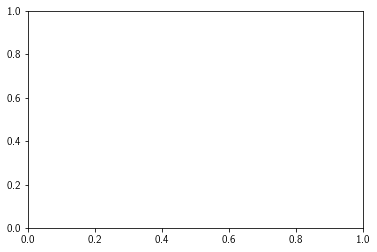

In [119]:
N = 500

Es = np.array(
      [0.0033, 0.0039, 0.0047, 0.0057, 
       0.0068, 0.0081, 0.0097, 0.0116, 
       0.0139, 0.0166, 0.0199, 0.0238, 
       0.0285, 0.0341, 0.0408, 0.0488, 
       0.0584, 0.0699, 0.0836, 0.1])


Ls = np.array([7, 9, 11, 13, 15]) # system size

# Parameters template
params_template = dict(L=15,
              T=100.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c1_f0",
              E=0.0,
              N=N,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)


# place store parameters
popts = np.zeros((len(Ls), len(Es), 3))
perrs = np.zeros((len(Ls), len(Es), 3))
t0s = np.zeros((len(Ls), len(Es)))

cmap = cm.get_cmap("nipy_spectral_r")
cs = [cmap((j+1) * (0.9)/(len(Es))) for j in range(len(Es))]

for i, L in enumerate(Ls):
    fig, ax = plt.subplots(1,1)
    params = copy(params_template)
    params.update({"L":L, "E": 0, "N": 1})
    Q0 = QCA(params, der=der)
    #Q0.run(tasks=["rhoj", "rhojk"], verbose=False)
    for j, (E, c) in enumerate(zip(Es, cs)):
        params.update({"E": E, "N":N})
       
        # run sims
        Q = QCA(params, der=der)
        #Q.run(tasks=["rhoj", "rhojk"], verbose=False)
        ts = Q.ts[1:]
        Cs = Q.C(2)[1:]
        Q.close()
        
        # fit exponential
        # fix the time shift to the first maximum
        # fix final time to last available
        t0 = np.argmax(Cs)
        t1 = -1
        def expfunc(t, A, tau, B):
            return A * np.exp( -(t-t0) / tau) + B
        # inital fit parameter guesses (A, tau, B),
        # may need to update for larger systems / different noise rates
        p0 = (0.1, 5, Cs[-1])
        # perform fit
        popt, pcov = curve_fit(
            expfunc, ts[t0:t1], Cs[t0:t1], # func, x data, y data
            p0=p0, # parameter guesses
            sigma=Cs[t0:t1], # weight small values more
            bounds=((0,0,0), (np.inf, np.inf,np.inf)) # parameter bounds
        )
        # standard error of fit parameter
        # TODO: what are the error units for an unweighted fit?
        perr = np.sqrt(np.diag(pcov))
       
        # record parameters
        popts[i, j, :] = popt
        perrs[i, j, :] = perr
        t0s[i, j] = t0
       
        ax.plot(
            ts, Cs, marker="o", mec="k", mfc=c, ls="none")
        ax.plot(
            ts[t0:t1], expfunc(ts[t0:t1], *popt),c="k")
        ax.set_ylabel(r"$\mathcal{C}$")
        ax.set_xlabel(r"$t$")
        ax.set_title(f"$L={L}$")
    # plot E=0 reference 
    ax.plot(
            Q0.ts[2:], Q0.C(2)[2:], marker="o", mfc="none", c="crimson")
    ax.set_yscale("log")
    
    
    params = copy(params_template)
    params.update({"L":15, "E": 0, "N": 500,"E": 0.02/3, "IC": "P123"})
    Q1 = QCA(params, der=der)
    # plot Porter-Thomas
    ax.plot(
            Q1.ts[2:], Q1.C(2)[2:], marker="o", mfc="none", c="k")
    
    ax.text(0.02,0.065,"Porter-\nThomas\n pure state",transform=ax.transAxes)
    fig.savefig(f"figures/C-fits_L{Q.L}_R{Q.R}_N{N}_depolarized.pdf", bbox_inches="tight")

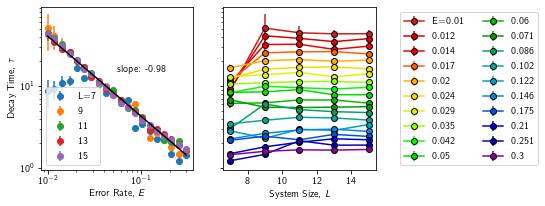

In [27]:
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)

# Plot decay time vs error rate for all system sizes
for i, L in enumerate(Ls):
    if i==0:
        label=f"L={L}"
    else:
        label=L
    axs[0].errorbar(Es*3, popts[i,:,1],
                    yerr=perrs[i,:,1],
                    label=label, 
                    marker="o",
                   ls="none")

# plot decay time vs system size for all error rates
for j, (E, c) in enumerate(zip(Es, cs)):
    E=round(E*3,3)
    if j==0:
        label=f"E={E}"
    else:
        label=E
    axs[1].errorbar(Ls, popts[:,j,1], 
                    yerr=perrs[:,j,1], 
                    label=label,
                    c=c,
                    mec="k",
                    marker="o")

# fit power law of decay time vs error rate to largest L data
x, y = Es*3, popts[i,:,1]
m,b = np.polyfit(np.log10(x), np.log10(y), deg=1)
def powerlaw(x):
    return 10**b * x ** m
axs[0].plot(x, powerlaw(x), c="k", zorder=100)
axs[0].text(0.5, 0.6, f"slope: {round(m,2)}", transform=axs[0].transAxes)

# scales and labels
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_ylabel(r"Decay Time, $\tau$")
axs[0].set_xlabel("Error Rate, $E$")
axs[0].legend(loc="lower left")
axs[1].set_xlabel("System Size, $L$")
axs[1].legend(loc="upper right", bbox_to_anchor=[2.1,1], ncol=2)

# save figure
fig.savefig(f"figures/decay_time_vs_E-L.pdf", bbox_inches="tight")

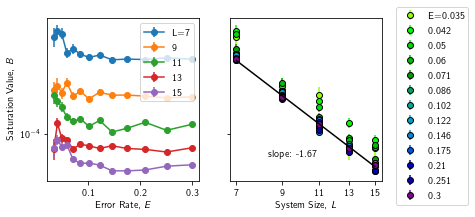

In [28]:
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
mindex=7

# Plot saturation value vs error rate for all system sizes
for i, L in enumerate(Ls):
    if i==0:
        label=f"L={L}"
    else:
        label=L
    axs[0].errorbar(Es[mindex:]*3, popts[i,mindex:,2],
                    yerr=perrs[i,mindex:,2],
                    label=label, 
                    marker="o")
    
# plot saturation value vs system size for all error rates
for j, (E, c) in enumerate(zip(Es[mindex:], cs[mindex:])):
    j+=mindex
    E=round(E*3,3)
    if j==mindex:
        label=f"E={E}"
    else:
        label=E
    axs[1].errorbar(Ls, popts[:,j,2], 
                    yerr=perrs[:,j,2], 
                    label=label,
                    ls="none",
                    c=c,
                    mec="k",
                    ecolor=c,
                    marker="o")


# fit power law of saturation value vs system size for largest error rate
x, y = Ls, popts[:,j,2]
m,b = np.polyfit(np.log10(x), np.log10(y), deg=1)
def powerlaw(x):
    return 10**b * x ** m
axs[1].plot(x, powerlaw(x), c="k",zorder=100)
axs[1].text(0.25, 0.15, f"slope: {round(m,3)}", transform=axs[1].transAxes)

# scales and labels
axs[0].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_xticks(Ls)
axs[1].set_xticklabels(Ls)
axs[1].minorticks_off()

axs[0].set_ylabel(r"Saturation Value, $B$")
axs[0].set_xlabel("Error Rate, $E$")
axs[0].legend(loc="upper right")
axs[1].set_xlabel("System Size, $L$")
axs[1].legend(loc="upper right", bbox_to_anchor=[1.6,1.1])

# save figure
fig.savefig(f"figures/sat-val_vs_E-L.pdf", bbox_inches="tight")

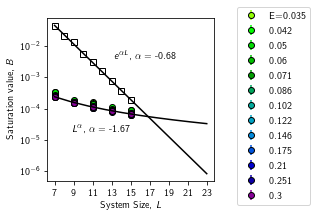

In [26]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
mindex=7
x2 = np.linspace(7,23,10)
    
# plot saturation value vs system size for all error rates
for j, (E, c) in enumerate(zip(Es[mindex:], cs[mindex:])):
    j+=mindex
    E=round(E*3,3)
    if j==mindex:
        label=f"E={E}"
    else:
        label=E
    ax.errorbar(Ls, popts[:,j,2], 
                    yerr=perrs[:,j,2], 
                    label=label,
                    ls="none",
                    c=c,
                    mec="k",
                    ecolor=c,
                    marker="o")


# fit power law of saturation value vs system size for largest error rate
x, y = Ls, popts[:,j,2]
m,b = np.polyfit(np.log10(x), np.log10(y), deg=1)
def powerlaw(x):
    return 10**b * x ** m
ax.plot(x2, powerlaw(x2), c="k",zorder=100)
ax.text(0.15, 0.3,  r"$L^{\alpha},\,\alpha=$  %s"%round(m,2), transform=ax.transAxes)


# Porter Thomas random state scaling
x, y = RLs, RnetCs
m,b = np.polyfit(x, np.log(y), deg=1)
def explaw(x):
    return np.exp(b  +m *x)
ax.plot(x2, explaw(x2), c="k",zorder=100)
ax.plot(x, y, mec="k", marker="s", mfc="none", ls="none")
ax.text(0.4, 0.75, r"$e^{\alpha L},\,\alpha=$  %s"%round(m,2), transform=ax.transAxes)




# scales and labels
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xticks(np.hstack((Ls , [17, 19, 21, 23])))
ax.set_xticklabels(np.hstack((Ls , [17, 19, 21, 23])))
ax.minorticks_off()

ax.set_ylabel(r"Saturation value, $B$")
ax.set_xlabel("System Size, $L$")
ax.legend(loc="upper right", bbox_to_anchor=[1.6,1.1])

# save figure
fig.savefig(f"figures/PT-random_R6-sat-val_vs_L.pdf", bbox_inches="tight")

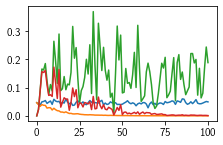

In [114]:
# Parameters template
params_template = dict(
              L=7,
              T=100.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c1_f0",
              E=0.0,
              N=500,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

# define variable parameters
ICs = ["P123", "c1_f0"]    # seeded random throw, centered bit flip
markers = ["o", "v"]
Es = [0.0, 0.02/3] # error rate
colors = ("crimson", "k")

# initialize plots
fig, ax = plt.subplots(1,1, figsize=(3.375, 3.375/1.6))

# loop through variable parameters
for IC, m in zip(ICs, markers):
    for E, c in zip(Es, colors):
        params = copy(params_template)
        params.update({"IC": IC, "E": E})
        if E == 0.0:
            params.update({"N":1})
        Q = QCA(params, der=der)
        #Q.run(tasks=["rhoj", "rhojk", "bipart"], verbose=True)
        ax.plot(Q.ts, Q.C(2))

In [111]:
Q.ts[-1]

100.0